# LISA Sensitivity Notebook

#### Import relevant libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import LISA_tools as LISA

## Set physical and LISA constants

In [2]:
""" Constants """
C = 299792458.         # m/s
YEAR = 3.15581497632e7 # sec
TSUN = 4.92549232189886339689643862e-6 # mass of sun in seconds (G=C=1)
H0 = 69.6           # Hubble parameter today
Omega_m = 0.286     # density parameter of matter
MPC = 3.08568025e22 # mega-Parsec in meters

""" LISA arm length """
L = 2.5e9 # meters

""" Transfer Frequency """
f_star = C/(2.*np.pi*L)

""" Observation Period """
Tobs = 4.*YEAR

""" Number of Michelson Data Channels """
NC = 2

## Construct, Plot, and save to dat file, the characteristic noise strain for specified observation period

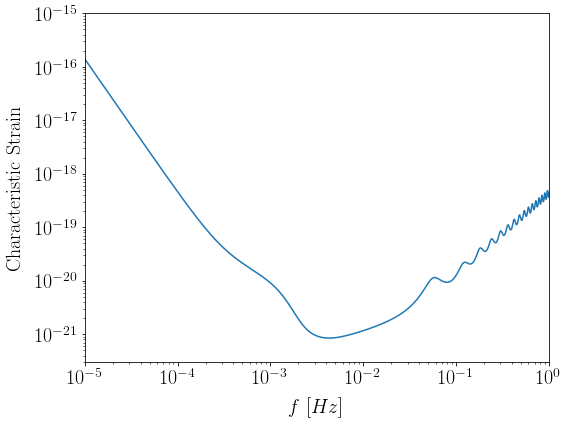

In [3]:
"""
Construct Noise curve
"""

""" Read in Transfer Function """
transfer_data = np.genfromtxt('R.txt')
f = transfer_data[:,0]*f_star # convert to frequency
R = transfer_data[:,1]*NC     # response gets improved by more data channels

"""
Calculate, Plot, and save the noise curve
"""
Sn = LISA.get_Pn(f)/R + LISA.get_Sc_est(f, Tobs)

plt.figure(figsize=(8,6))
plt.rc('text', usetex=True)
plt.rc('font', family='calibri')
plt.xlabel(r'$f ~[Hz]$', fontsize=20, labelpad=10)
plt.ylabel(r'Characteristic Strain$', fontsize=20, labelpad=10)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.loglog(f, np.sqrt(f*Sn)) # plot the characteristic strain

plt.xlim(1.0e-5, 1.0e0)
plt.ylim(3.0e-22, 1.0e-15)
plt.tight_layout()
plt.tick_params(labelsize=20)

plt.show()

out_file = 'characteristic_noise_strain.dat'
np.savetxt(out_file,(np.vstack((f, np.sqrt(f*Sn))).T), delimiter=' ')

## Calculate Characteristic Strain, plot it appropriately, and save to dat file

Track SNR: 4.87056369682


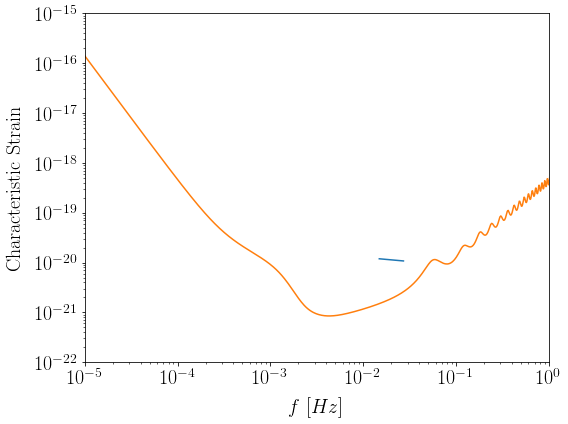

In [8]:
"""
Calculate the Characteristic strain of the source

Inputs:
    m1 - component mass 1
    m2 - component mass 2
    
    Initial condition options (Specify one!)
    --------------------------
    T_merger - time to merger for source
    f_start  - start frequency for source
    
    Distance options (Specify one!)
    --------------------------
    D_lum - Luminosity distance
    z - redshift
"""

test_flag=2

if (test_flag == 0):
    """ Binary Black Hole test source """
    m1 = 0.5e6*TSUN # leading coefficient is the mass in terms of solar mass
    m2 = 0.5e6*TSUN

    D_lum    = None     # Luminosity Distance, meters
    z        = 3.       # Redshift
    T_merger = 1.*YEAR  # time to merger
    f_start  = None     # start frequency

elif (test_flag == 1): 
    """ GB test source """
    m1 = 0.50*TSUN # leading coefficient is the mass in terms of solar mass
    m2 = 0.25*TSUN

    D_lum    = 1.0e-3*MPC # Luminosity Distance, meters
    z        = None       # Redshift
    T_merger = None       # time to merger
    f_start  = 2.6e-3     # start frequency
    
elif (test_flag == 2): 
    """ GW150914, 5 years from merger """
    m1 = 36.*TSUN # leading coefficient is the mass in terms of solar mass
    m2 = 29.*TSUN

    D_lum    = 410.*MPC   # Luminosity Distance, meters
    z        = None       # Redshift
    T_merger = 5.*YEAR    # time to merger
    f_start  = None       # start frequency


"""
PhenomA: Binary Waveform
--------------
Section 2 of ``LISA Sensitivity'' -Neil Cornish
"""

"""
Coefficients from Table 2 in ``LISA Sensitivity'' -Neil Cornish
"""

a3 = 8.4845e-1
b3 = 1.2848e-1
c3 = 2.7299e-1


def calculate_plot_source(m1, m2, Dl=None, z=None, T_merger=None, f_start=None):
    """
    Determine the appropriate way to plot the source, calculate its characteristic strain
    and print the correpsonding SNR.
    """
    
    """ Sort out the luminosity distance and redshift of the source """
    if (Dl==None): # Z was specified, then we must calculate Dl
        Dl = LISA.get_Dl(z)
    elif(z==None):
        z = optimize.root(LISA.get_z, 1., args=(Dl)).x[0]

    """ Calculate relevant mass parameters """
    m1 *= (1. + z)
    m2 *= (1. + z)
    M = m1 + m2                           # total mass
    M_chirp = (m1*m2)**(3./5.)/M**(1./5.) # chirp mass
    eta = (m1*m2)/M**2                    # symmetric mass ratio   
    
    """ Calculate PhenomA cut-off frequency """
    f3 = (a3*eta**2 + b3*eta + c3)/(np.pi*M) 
        
    if (f_start==None): # T_merger was specified
        f_start = (5.*M_chirp/T_merger)**(3./8.)/(8.*np.pi*M_chirp)
    else: # f_start was specified, calculate time to merger for circular binary
        T_merger = 5.*M_chirp/(8.*np.pi*f_start*M_chirp)**(8./3.)
        
    """ Determine the ending frequency of this source """
    if (T_merger > Tobs):
        f_end = (5.*M_chirp/(np.abs(Tobs-T_merger)))**(3./8.)/(8.*np.pi*M_chirp)
    elif (T_merger <= Tobs):
        f_end = f3
        
    """ Plot the results """
    plt.figure(figsize=(8,6))
    plt.rc('text', usetex=True)
    plt.rc('font', family='calibri')
    plt.xlabel(r'$f ~[Hz]$', fontsize=20, labelpad=10)
    plt.ylabel(r'Characteristic Strain$', fontsize=20, labelpad=10)
    plt.tick_params(axis='both', which='major', labelsize=20)
    
    # How much log bandwidth does the source span
    d_log_f = np.log(f_end/f_start)
  
    if (d_log_f > 0.5): # plot a track
        A_arr   = np.zeros(len(f))
        Sh_arr  = np.zeros(len(f))
        h_c_arr = np.zeros(len(f))
        
        arg_start = np.where(f<=f_start)[0][-1]
        if (f_end > 1.): # i.e. off the graph
            arg_end = np.len(f)-1
        else:
            arg_end = np.where(f>=f_end)[0][0]
        
        for i in range(arg_start, arg_end):
            A_arr[i] = LISA.get_A(f[i], M, eta, M_chirp, Dl) 
            h_c_arr[i] = f[i]*A_arr[i]*np.sqrt(16./5.) # characteristic strain
            
        plt.loglog(f, h_c_arr)
        out_file = 'char_signal_strain.dat'
        np.savetxt(out_file,(np.vstack((f, h_c_arr)).T), delimiter=' ')
        
        SNR = 0.
        for i in range(arg_start, arg_end):
            freq   = 0.5*(f[i] + f[i-1])
            Sn_est = 0.5*(1./Sn[i] + 1./Sn[i-1])
            SNR += 16./5.*freq*LISA.get_A(freq, M, eta, M_chirp, Dl)**2*Sn_est*(np.log(f[i]) - np.log(f[i-1]))
        SNR = np.sqrt(SNR)

        print "Track SNR: " + str(SNR)
        

    else: # track is too short, plot a point
        h_c = np.sqrt(16./5.*(f_end-f_start)*f_start)*LISA.get_A(f_start, M, eta, M_chirp, Dl)
        plt.loglog(f_start, h_c, 'r.')
        out_file = 'char_signal_strain.dat'
        np.savetxt(out_file,(np.vstack((f_start, h_c)).T), delimiter=' ')
        
        Sn_est = LISA.get_Sn_approx(f_start) + get_Sc_est(f_start, Tobs)
        SNR = 8.*np.sqrt(Tobs/5.)*M_chirp**(5./3.)*(np.pi*f_start)**(2./3.)/(Dl/C)/np.sqrt(Sn_est)
        print "Point SNR: " + str(SNR)
    
    plt.loglog(f, np.sqrt(f*Sn)) # plot the characteristic strain of noise

    plt.xlim(1.0e-5, 1.0e0)
    plt.ylim(1.0e-22, 1.0e-15)
    plt.tight_layout()
    plt.tick_params(labelsize=20)

    plt.show()
    
    return None

calculate_plot_source(m1, m2, Dl=D_lum, z=z, T_merger=T_merger, f_start=f_start)